# JAL-AM

In [1]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from model_lib import *
from JAL_AM_lib import *

# Single run of JAL-AM

In [14]:
k = np.linspace(0,1,7)
a, b, c = JAL_AM(0.3, 0.95, 500000, k)

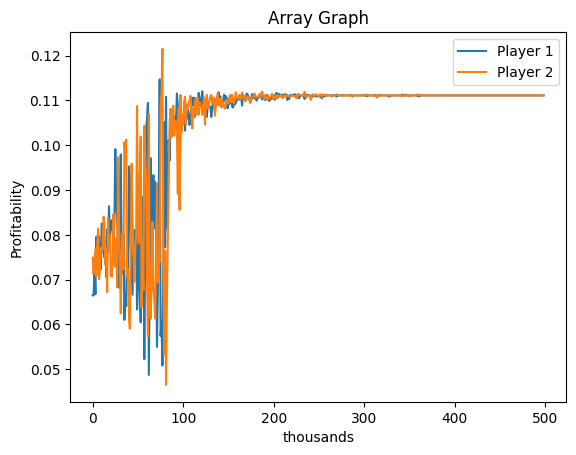

In [15]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

# n runs of JAL-AM

In [20]:
avg_prof,prof_gain,edge,focal= run_sim(100, np.linspace(0,1,25))

JAL-AM: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


In [21]:
print("Edgeworth price cycles: ", edge)
print("Focal pricing: ", focal)

Edgeworth price cycles:  95
Focal pricing:  5


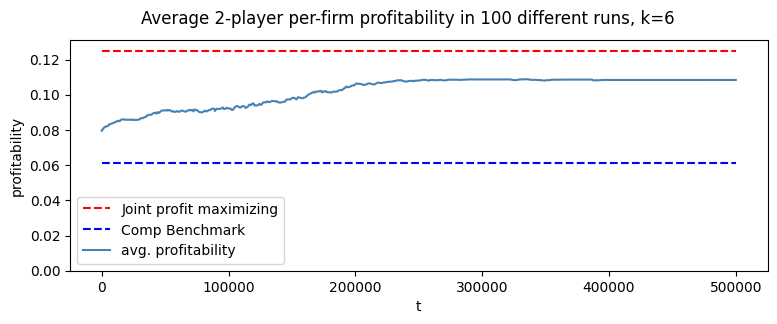

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(100, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [23]:
avg_prof[498]

0.1083883072916667

# Average profit gain

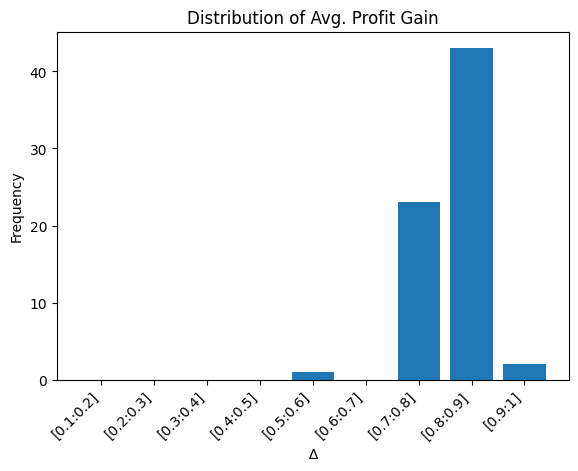

In [ ]:
# Define the intervals
intervals = [(0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)]
intervals_str = ['[0.1:0.2]','[0.2:0.3]', '[0.3:0.4]', '[0.4:0.5]', '[0.5:0.6]', '[0.6:0.7]', '[0.7:0.8]', '[0.8:0.9]', '[0.9:1]']

# Initialize an array to store counts for each interval
interval_counts = np.zeros(len(intervals), dtype=int)

# Iterate through the array and count values in each interval
for num in prof_gain:
    for i, interval in enumerate(intervals):
        if interval[0] <= num < interval[1]:
            interval_counts[i] += 1

# Plot the counts for each interval
plt.bar(np.arange(len(intervals)), interval_counts, tick_label=intervals_str)
plt.xticks(rotation=45, ha='right')
plt.xlabel('∆')
plt.ylabel('Frequency')
plt.title('Distribution of Avg. Profit Gain')
plt.subplots_adjust(top=0.925, 
                    bottom=0.20, 
                    left=0.1, 
                    right=0.90, 
                    hspace=0.01, 
                    wspace=0.01)
plt.savefig('Graphs/avg_prof_gain_jalam')
plt.show()

# Assymetric information

In [11]:
avg_prof_asym,prof_gain,n, firm1, firm2= run_sim_asym(100, np.linspace(0,1,7),0.2)

In [3]:
res, avg_prof_gain,edge, focal = run_sim(100, np.linspace(0,1,7))

JAL-AM: 100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


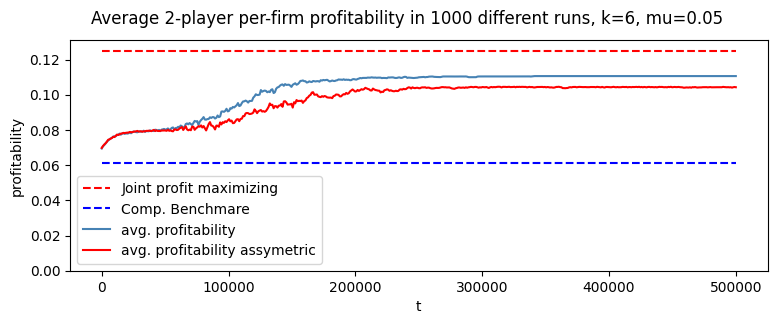

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}, mu={}".format(1000,6, 0.05))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp. Benchmare')#konstant taget fra johanne og morten
axs.plot(xs,res,color="steelblue", label ="avg. profitability")
axs.plot(xs, avg_prof_asym, color="red", label = "avg. profitability assymetric")

axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [13]:
avg_prof_asym[498]

0.10424930555555646

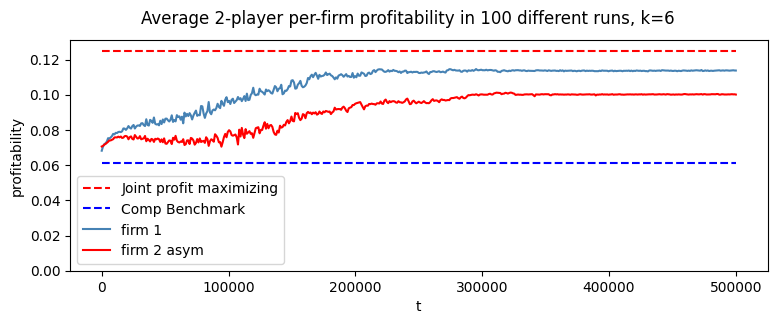

In [5]:
##
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(n, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark')
axs.plot(xs, firm1, color="steelblue", label = "firm 1")
axs.plot(xs, firm2, color="red", label = "firm 2 asym")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [18]:
@njit
def calculate_AV(s, a, Q, agent_model_j):
    """
    Args:
        s: The current state
        a: current action
        Q: The Q-value table
        agent_model_j: The estimated policy of the other agent
    returns
        AV: action value 
    """
    AV = Q[s, a, s] * agent_model_j[s,a] # Skal måske skiftes?
    return AV

@njit
def max_AV(s, Q, agent_model_j, price_grid):
    AVs = np.empty(len(price_grid))
    for i in range(len(price_grid)):
        AVs[i] = calculate_AV(s, i, Q, agent_model_j)
    return np.argmax(AVs)


@njit
def update_agent_model(agent_model, state, action, counter,k):
    """
    args:
        state: the current state of player j
        action: action of player j
        counter: array holding count of every action played in each state
    returns:
        counter: the updated counter
        agent_model: the updated agent model
    """
    counter[state, action] += 1
    total_actions = np.sum(counter[state,:])

    for i in range(k):
        agent_model[state,i] = counter[state, i] / total_actions # updates column values
    

    return counter, agent_model

@njit
def select_price(s_idx, price_grid, epsilon, Q, agent_model_j):
    """
    args
        s_t_idx: current state index
        price_grid: price grid
        epsilon: decay parameter of learning module
        AV: action value
    returns
        random price in learning module or optimal price in action module
    """

    


    # exploration
    if epsilon >= np.random.uniform(0, 1):
        return np.random.choice(price_grid)
    # explotation
    else:
        best_a_idx = max_AV(s_idx, Q, agent_model_j, price_grid)
        return price_grid[best_a_idx]
    
        #maxedAV_idx = max(calculate_AV(s_idx, , Q, agent_model_j))
        #return price_grid[maxedAV_idx]

@njit
def Q_func(p_idx, s_idx, i, j, t, alpha, gamma, p_table, Q, price_grid, s_next, agent_model_j):
    """
    args
        p_curr_idx: current price of player i as index
        s_curr_idx: current state of player i as index
        i: player 0
        j: player 1
        t: current period
        alpha: step-size parameter
        gamma: discount factor
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table for player i
        price_grid: price_grid
        s_next: next state for player i
        AV: action value
    returns:
        updated value for Q_table 
    """
    prev_est = Q[s_idx, p_idx, s_idx]
    max_AV_idx = max_AV(s_idx, Q, agent_model_j, price_grid)
    maxed_AV = price_grid[max_AV_idx]
    reward = profit(p_table[i, t], p_table[j, t-2]) + gamma * profit(p_table[i, t], s_next) + gamma * maxed_AV
    return (1 - alpha) * prev_est + alpha * reward

@njit
def JAL_AM2(alpha, gamma, T, price_grid):
    """
    args
        alpha: step-size parameter
        gamma: discount factor
        T: number of runs
        price_grid: price grid
    returns
        p_table: 2x500.000 array storing prices for player 0 and 1
        avg_profs1: average profitabilities for player 1
        avg_profs2: average profitabilities for player 2
    """
    # initializing parameter values
    epsilon = calculate_epsilon(T)
    i, j = 0, 1
    t = 0
    k = len(price_grid)
    # initializing  q-tables, agent models, action values and counters 
    q1, q2 = np.zeros((k, k, k)), np.zeros((k, k, k))  # Adjust dimensions to handle joint actions
    Agent_model_1, Agent_model_2 = np.ones((k,k)) / k, np.ones((k,k)) / k
    AV_1, AV_2 = np.ones((k, k)), np.ones((k, k))
    N1, N2 = np.zeros((k, k)), np.zeros((k, k))

    p_table = np.zeros((2, T))
    profits = np.zeros((2, T))
    avg_profs1, avg_profs2 = [], []
    # setting prices for players in first 2 periods 
    p_table[i, t] = np.random.choice(price_grid)
    p_table[j, t] = np.random.choice(price_grid)
    t += 1
    p_table[i, t] = np.random.choice(price_grid)
    p_table[j, t] = np.random.choice(price_grid)
    t += 1 # now t = 2
    
    for t in range(t, T):
        # updating counter, action value and q-table
        p_table[i, t] = p_table[i, t-1] 
        p_idx = np.where(price_grid == p_table[i, t])[0][0] # p_it-1
        s_next = p_table[j, t-1] # p_jt-1
        current_state_idx = np.where(price_grid == p_table[j, t-2])[0][0] # p_jt-2

        N2, Agent_model_2 = update_agent_model(Agent_model_2, p_idx, current_state_idx, N2, k)
        q1[current_state_idx, p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, i, j, t, alpha, gamma, p_table, q1, price_grid, s_next, Agent_model_1)
        # setting price
        s_next_idx = np.where(price_grid == p_table[j, t-1])[0][0]
        
        p_table[i, t] = select_price(s_next_idx, price_grid, epsilon[t], q1, Agent_model_1)
        p_table[j, t] = p_table[j, t-1]
        # store profits for both firms
        profits[i, t] = profit(p_table[i, t], p_table[j, t])
        profits[j, t] = profit(p_table[j, t], p_table[i, t])
        # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            avg_profs1.append(np.sum(profits[i, (t-1000):t]) / 1000)
            avg_profs2.append(np.sum(profits[j, (t-1000):t]) / 1000)
        # changing agents
        i, j = j, i
        q1, q2 = q2, q1
        Agent_model_1, Agent_model_2 = Agent_model_2, Agent_model_1
        N1, N2 = N2, N1
        AV_1, AV_2 = AV_2, AV_1
    
    return p_table, avg_profs1, avg_profs2

In [22]:
k = np.linspace(0,1,7)
a, b, c = JAL_AM2(0.3, 0.95, 500000, k)

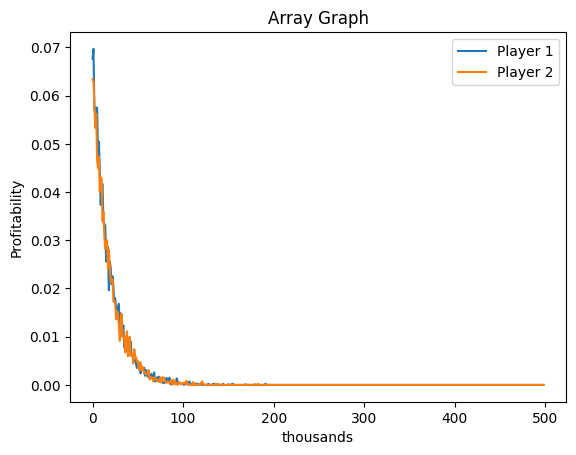

In [23]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [144]:
def run_sim(n, k):
    """
    args:
        n: number of runs simulated
        k: length of price action vector
    returns:
        avg_avg_profitabilities: average of average profits over n simulations
        avg_prof_gain: list containing average profit gains of runs
        edge: number of times simulations resulted in Edgeworth price cycle
        focal: number of times simulations resulted in focal price
    """
    # initalizing values
    num_calcs=int(5000000/1000-1) # size of avg. profits 
    summed_avg_profitabilities = np.zeros(num_calcs)
    avg_prof_gain = np.zeros((n))
    focal = 0
    edge = 0
    # simulating n runs of JAL-AM
    for i in tqdm(range(n), desc='JAL-AM', leave=True):
        p_table, avg_profs1, avg_profs2 = JAL_AM2(0.3, 0.95, 5000000, k)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        avg_prof_gain[i] = per_firm_profit[498]/0.125
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
        edge, focal, p_m = edge_or_focal(edge, focal, p_table)
    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    return avg_avg_profitabilities, avg_prof_gain, edge, focal

In [150]:
avg_prof,prof_gain,edge,focal= run_sim(100, np.linspace(0,1,25))

JAL-AM: 100%|██████████| 100/100 [06:24<00:00,  3.84s/it]


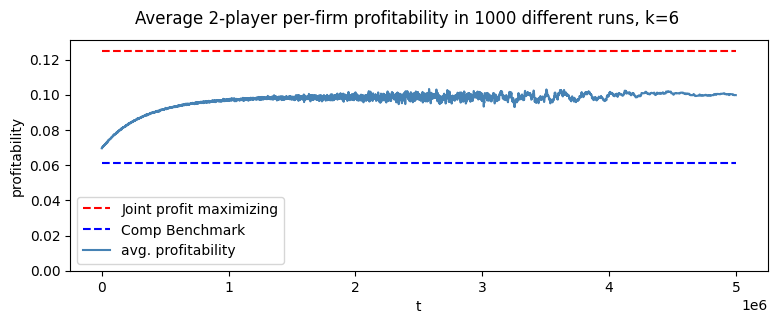

In [151]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(1000, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 5000000, 4999)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof-0.01, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [154]:
avg_prof[498]

0.10188528645833328

In [155]:
print("Edgeworth price cycles: ", edge)
print("Focal pricing: ", focal)

Edgeworth price cycles:  0
Focal pricing:  100


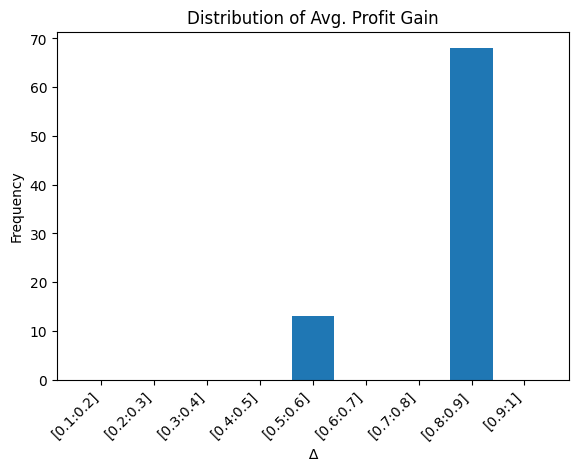

In [130]:
# Define the intervals
intervals = [(0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)]
intervals_str = ['[0.1:0.2]','[0.2:0.3]', '[0.3:0.4]', '[0.4:0.5]', '[0.5:0.6]', '[0.6:0.7]', '[0.7:0.8]', '[0.8:0.9]', '[0.9:1]']

# Initialize an array to store counts for each interval
interval_counts = np.zeros(len(intervals), dtype=int)

# Iterate through the array and count values in each interval
for num in prof_gain:
    for i, interval in enumerate(intervals):
        if interval[0] <= num < interval[1]:
            interval_counts[i] += 1

# Plot the counts for each interval
plt.bar(np.arange(len(intervals)), interval_counts, tick_label=intervals_str)
plt.xticks(rotation=45, ha='right')
plt.xlabel('∆')
plt.ylabel('Frequency')
plt.title('Distribution of Avg. Profit Gain')
plt.subplots_adjust(top=0.925, 
                    bottom=0.20, 
                    left=0.1, 
                    right=0.90, 
                    hspace=0.01, 
                    wspace=0.01)
plt.savefig('Graphs/avg_prof_gain_jalam')
plt.show()